In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
import albumentations as A
import mermaidseg.datasets.dataset
import numpy as np
from mermaidseg.io import setup_config, get_parser, update_config_with_args
import copy
import torch
from matplotlib import pyplot as plt

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True

CUDA Device 0: Tesla T4


In [4]:
from torch.utils.data import DataLoader, random_split
from mermaidseg.model.meta import MetaModel
from mermaidseg.model.eval import EvaluatorSemanticSegmentation
from mermaidseg.logger import Logger
from mermaidseg.model.train import train_model

2025-12-02 15:45:07.057075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 15:45:07.110451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764690307.134647   31088 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764690307.144348   31088 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 15:45:07.180737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Config

In [5]:
# Start off with a configuration file
cfg = setup_config(config_path='../configs/linear-dinov2-base-concept.yaml', config_base_path='../configs/concept_mermaid.yaml')

# Update the initial configuration file with command line arguments 
# (in the case of a notebook run these can be defined explicitly here)
args_input = "--run-name=notebook_test_run --batch-size=4 --epochs=5 --log-epochs=1"
args_input = args_input.split(" ")

parser = get_parser()
args = parser.parse_args(args_input)

cfg = update_config_with_args(cfg, args)
cfg_logger = copy.deepcopy(cfg)

# 2. Data

In [6]:
transforms = {}
for split in cfg.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg.augmentation[split].items()
        ]
    )

In [7]:
dataset_name = cfg.data.pop("name", None)
batch_size = cfg.data.pop("batch_size", 8)
dataset = getattr(mermaidseg.datasets.dataset, dataset_name)(transform = transforms["train"], **cfg.data)

In [8]:
len(dataset)

7542

In [9]:
dataset.num_classes, dataset.num_concepts

(16, 20)

In [10]:
dataset.benthic_concept_matrix

,Acropora,Acroporidae,Bare substrate,Crustose coralline algae,Hard coral,Macroalgae,Millepora,Milleporidae,Montipora,Other,Pocillopora,Pocilloporidae,Porites,Porites lobata,Poritidae,Rubble,Sand,Soft coral,Tape,Turf algae
Macroalgae,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Rubble,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Sand,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Porites,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
Crustose coralline algae,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bare substrate,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Hard coral,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Turf algae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Millepora,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Tape,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


(3, 518, 518) (518, 518)


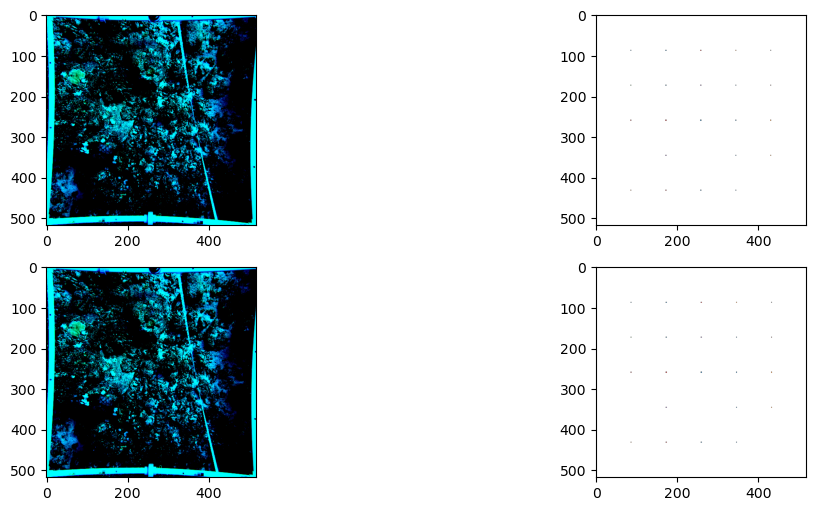

In [11]:
fig, ax = plt.subplots(figsize= (13,6), ncols = 2, nrows = 2)

image, mask, annotations = dataset[0]
print(image.shape, mask.shape)

ax[0, 0].imshow(image.transpose(1,2,0))
ax[0, 1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=15)

image, mask, annotations = dataset[0]

ax[1, 0].imshow(image.transpose(1,2,0))
ax[1, 1].imshow(np.where(mask>0, mask, np.nan), cmap = "tab10", vmin=1, vmax=15)

plt.show()

In [12]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
# train_dataset = torch.utils.data.Subset(train_dataset, range(200))
# val_dataset = torch.utils.data.Subset(val_dataset, range(100))
# test_dataset = torch.utils.data.Subset(test_dataset, range(100))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True, collate_fn = dataset.collate_fn)

In [13]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1319
Number of validation batches: 188
Number of test batches: 377


# 3. Model

In [14]:
meta_model = MetaModel(run_name = cfg.run_name, 
                       num_classes = dataset.num_concepts,
                       device = device,
                       model_kwargs = cfg.model,
                       training_kwargs = cfg.training,
                       concept_matrix = dataset.benthic_concept_matrix
                       )

In [15]:
# evaluator = EvaluatorSemanticSegmentation(num_classes=dataset.num_classes,
#                                             device=device,
#                                             )
from torchmetrics.classification import F1Score, JaccardIndex

metric_dict = {
            "f1_class": F1Score(task="multiclass", average = "none", num_classes=3, ignore_index = 0).to(device),
            "mean_iou": JaccardIndex(task="multiclass", num_classes=3, ignore_index = 0).to(device),
            "iou": JaccardIndex(task="multiclass", num_classes=3, ignore_index = 0, average='none').to(device)
            }

evaluator = EvaluatorSemanticSegmentation(num_classes=dataset.num_concepts,
                                            device=device,
                                            metric_dict = metric_dict
                                            )

In [16]:
from mermaidseg.logger import Logger

logger = Logger(
    config = cfg_logger,
    meta_model = meta_model,
    log_epochs = cfg.logger.log_epochs,
    log_checkpoint = 2, #cfg.logger.log_checkpoint
    checkpoint_dir = ".",
    enable_mlflow = False
)

In [ ]:
from mermaidseg.model.train import train_model
train_model(meta_model, evaluator, train_loader, val_loader, logger=logger, metric_of_interest="mean_iou")

EPOCH: 0


  0%|          | 0/1319 [00:00<?, ?it/s]

100%|██████████| 1319/1319 [33:30<00:00,  1.52s/it]


LOSS train 0.15686108358910447
TRAIN METRICS: {'f1_class': array([0.        , 0.97114325, 0.2445708 ], dtype=float32), 'mean_iou': 0.5416138768196106, 'iou': array([0.        , 0.94390523, 0.13932252], dtype=float32)}


100%|██████████| 188/188 [02:52<00:00,  1.09it/s]


LOSS valid 0.14698532837978068
VALID METRICS: {'f1_class': array([0.        , 0.9722002 , 0.23470709], dtype=float32), 'mean_iou': 0.5394303798675537, 'iou': array([0.        , 0.94590425, 0.13295646], dtype=float32)}
EPOCH: 1


100%|██████████| 1319/1319 [32:24<00:00,  1.47s/it]


LOSS train 0.1304957731439816
TRAIN METRICS: {'f1_class': array([0.        , 0.9741866 , 0.42356253], dtype=float32), 'mean_iou': 0.609177827835083, 'iou': array([0.        , 0.9496723 , 0.26868337], dtype=float32)}


100%|██████████| 188/188 [02:47<00:00,  1.12it/s]


LOSS valid 0.12480723374384514
VALID METRICS: {'f1_class': array([0.        , 0.9759669 , 0.50040203], dtype=float32), 'mean_iou': 0.643376350402832, 'iou': array([0.        , 0.9530619 , 0.33369082], dtype=float32)}
EPOCH: 2


 47%|████▋     | 620/1319 [14:50<17:10,  1.47s/it]

In [ ]:
# from mermaidseg.datasets.concepts import labels_to_concepts

In [ ]:
# data = next(iter(train_loader))
# _, labels = data
# labels = labels.long().to(meta_model.device)
# outputs, loss = meta_model.batch_predict_loss(data)

In [ ]:
# concept_labels = labels_to_concepts(labels, meta_model.concept_matrix)

In [ ]:
# outputs_sig = torch.sigmoid(outputs)

In [ ]:
# outputs_max = np.where(outputs_sig.cpu().detach().numpy()>=0.5, 1,0)

In [ ]:
# np.unique(outputs_max, return_counts=True)

(array([0, 1]), array([21080990,   384930]))

In [ ]:
# outputs_max+=1

In [ ]:
# np.unique(outputs_max, return_counts=True)

(array([1, 2]), array([21080990,   384930]))

In [ ]:
# outputs_max *= (labels.unsqueeze(1).cpu().detach().numpy()!=0)

In [ ]:
# np.unique(outputs_max, return_counts=True)

(array([0, 1, 2]), array([21453840,    11656,      424]))

In [ ]:
# concept_labels+= 1 
# concept_labels = concept_labels.cpu().detach().numpy()
# concept_labels *= (labels.unsqueeze(1).cpu().detach().numpy()!=0)

In [ ]:
# (labels.unsqueeze(1).cpu().detach().numpy()!=0).sum()*20

np.int64(12080)

In [ ]:
# np.unique(concept_labels, return_counts=True)

(array([0., 1., 2.], dtype=float32), array([21453840,    11452,      628]))

In [ ]:

# concept_labels = labels_to_concepts(labels, meta_model.concept_matrix)
# # concept_labels = concept_labels.to(meta_model.device).float()
# outputs = torch.sigmoid(outputs)
# outputs = np.where(outputs.cpu().detach().numpy()>0.5, 1,0)
# outputs += 1 
# outputs *= (labels.unsqueeze(1).cpu().detach().numpy()==0)
# concept_labels+= 1 
# concept_labels = concept_labels.cpu().detach().numpy()
# concept_labels *= (labels.unsqueeze(1).cpu().detach().numpy()==0)

In [ ]:
# np.unique(concept_labels)

array([0., 1.], dtype=float32)

In [ ]:
# outputs.shape, concept_labels.shape

((4, 20, 518, 518), (4, 20, 518, 518))

In [ ]:
# np.unique(outputs), np.unique(concept_labels)

(array([0, 1, 2]), array([0., 1., 2.], dtype=float32))

In [ ]:
# # do the thresholding on-device with torch (no numpy conversion)
# outputs = torch.sigmoid(outputs)
# outputs = (outputs > 0.5).float()  # stays on the same device as `outputs`

In [ ]:
# import tqdm
# for data in tqdm.tqdm(train_loader):
#     _, labels = data
#     labels = labels.long().to(meta_model.device)
#     outputs, loss = meta_model.batch_predict_loss(data)
#     if meta_model.concept_matrix is not None and evaluator is not None:
#         concept_labels = labels_to_concepts(labels, meta_model.concept_matrix)
#         concept_labels = concept_labels.to(meta_model.device).float()

#         outputs = torch.sigmoid(outputs)
#         outputs = (outputs > 0.5).float()  # stays on the same device as `outputs`

#         outputs += 1 
#         outputs *= (labels.unsqueeze(1) != 0)

#         concept_labels+= 1 
#         # concept_labels = concept_labels.cpu().detach().numpy()
#         concept_labels *= (labels.unsqueeze(1) != 0)
        
#         ## Update metrics
#         for metric in evaluator.metric_dict.values():
#             metric.update(outputs, concept_labels)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


In [ ]:
# metric_results = {}

# for metric_name in evaluator.metric_dict:
#     metric_results[metric_name] = (
#         evaluator.metric_dict[metric_name].compute().cpu().numpy()
#     )
#     if metric_results[metric_name].ndim == 0:
#         metric_results[metric_name] = metric_results[metric_name].item()
#     evaluator.metric_dict[metric_name].reset()

In [ ]:
# metric_results

{'f1_class': array([0.        , 0.97572446, 0.4725478 ], dtype=float32),
 'mean_iou': 0.6309847831726074,
 'iou': array([0.       , 0.952781 , 0.3108854], dtype=float32)}

In [ ]:
# import tqdm
# for data in tqdm.tqdm(train_loader):
#     _, labels = data
#     labels = labels.long().to(meta_model.device)
#     outputs, loss = meta_model.batch_predict_loss(data)
#     if meta_model.concept_matrix is not None and evaluator is not None:
#         concept_labels = labels_to_concepts(labels, meta_model.concept_matrix)
#         concept_labels = concept_labels.to(meta_model.device).float()

#         outputs = torch.sigmoid(outputs)
#         outputs = np.where(outputs.cpu().detach().numpy()>0.5, 1.0,0.0)
        
#         # outputs += 1 
#         # outputs *= (labels.unsqueeze(1).cpu().detach().numpy()!=0)

#         # concept_labels+= 1 
#         # concept_labels = concept_labels.cpu().detach().numpy()
#         # concept_labels *= (labels.unsqueeze(1).cpu().detach().numpy()!=0)
        
#         ## Update metrics
#         for metric in evaluator.metric_dict.values():
#             preds = torch.from_numpy(outputs).to(meta_model.device).long()
#             # targets = torch.from_numpy(concept_labels).to(meta_model.device).long()
#             metric.update(preds, targets)
# metric_results = {}

# for metric_name in evaluator.metric_dict:
#     metric_results[metric_name] = (
#         evaluator.metric_dict[metric_name].compute().cpu().numpy()
#     )
#     if metric_results[metric_name].ndim == 0:
#         metric_results[metric_name] = metric_results[metric_name].item()
#     evaluator.metric_dict[metric_name].reset()

In [ ]:
# from torchmetrics.classification import Accuracy, F1Score, JaccardIndex

# metric_dict = {
#             "f1_class": F1Score(task="multiclass", average = "none", num_classes=3, ignore_index = 0).to(device),
#             "mean_iou": JaccardIndex(task="multiclass", num_classes=3, ignore_index = 0).to(device),
#             "iou": JaccardIndex(task="multiclass", num_classes=3, ignore_index = 0, average='none').to(device)
#             }

# evaluator_final = EvaluatorSemanticSegmentation(num_classes=dataset.num_concepts,
#                                             device=device,
#                                             metric_dict = metric_dict
#                                             )

In [ ]:
# import tqdm
# for data in tqdm.tqdm(train_loader):
#     _, labels = data
#     labels = labels.long().to(meta_model.device)
#     outputs, loss = meta_model.batch_predict_loss(data)
#     if meta_model.concept_matrix is not None and evaluator_final is not None:
#         concept_labels = labels_to_concepts(labels, meta_model.concept_matrix)
#         concept_labels = concept_labels.to(meta_model.device).float()

#         outputs = torch.sigmoid(outputs)
#         outputs = np.where(outputs.cpu().detach().numpy()>0.5, 1.0,0.0)
        
#         outputs += 1 
#         outputs *= (labels.unsqueeze(1).cpu().detach().numpy()!=0)

#         concept_labels+= 1 
#         concept_labels = concept_labels.cpu().detach().numpy()
#         concept_labels *= (labels.unsqueeze(1).cpu().detach().numpy()!=0)
        
#         ## Update metrics
#         for metric in evaluator_final.metric_dict.values():
#             preds = torch.from_numpy(outputs).to(meta_model.device).long()
#             targets = torch.from_numpy(concept_labels).to(meta_model.device).long()
#             metric.update(preds, targets)

In [ ]:
# metric_results = {}

# for metric_name in evaluator_final.metric_dict:
#     metric_results[metric_name] = (
#         evaluator_final.metric_dict[metric_name].compute().cpu().numpy()
#     )
    
#     if metric_results[metric_name].ndim == 0:
#         metric_results[metric_name] = metric_results[metric_name].item()
        
#     evaluator_final.metric_dict[metric_name].reset()

# metric_results

In [ ]:
tmp = meta_model.model(next(iter(train_loader))[0].to(meta_model.device))

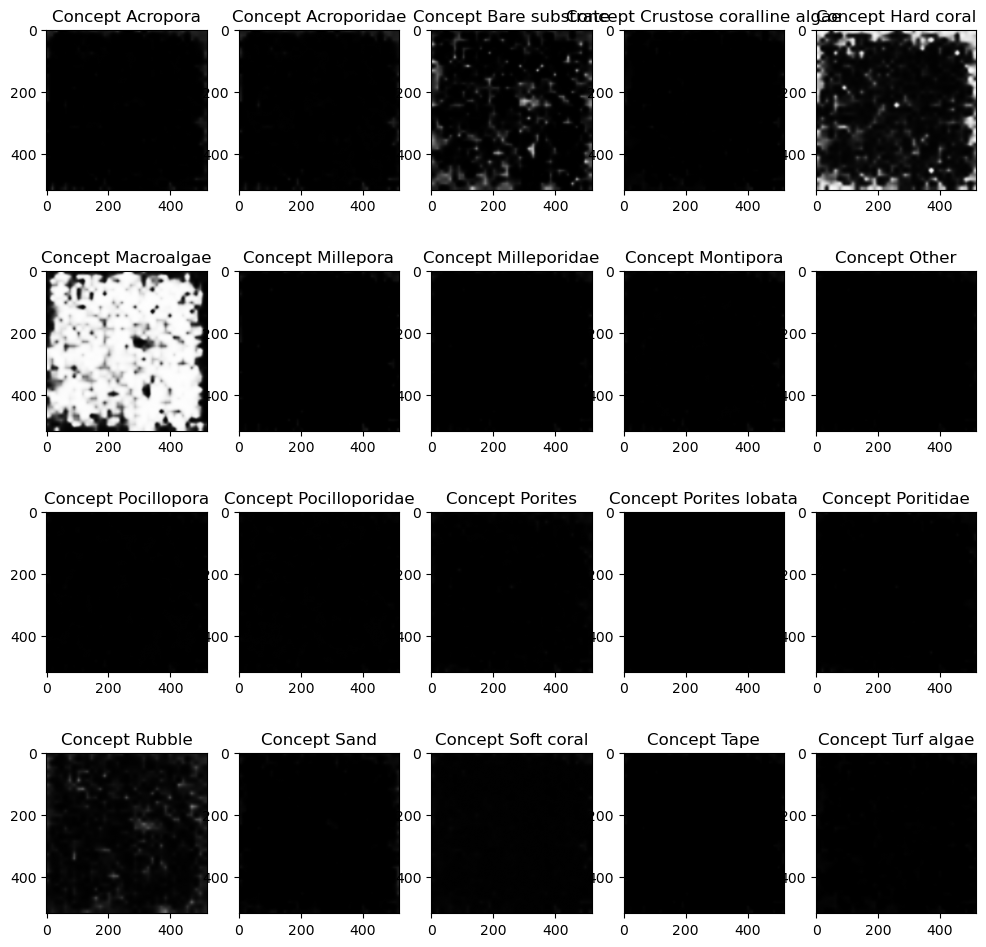

In [ ]:
fig, ax = plt.subplots(figsize=(12,12), nrows = 4, ncols = 5)
for i in range(20):
    sig = torch.sigmoid(tmp[0][i])
    plt.subplot(4,5,i+1)
    plt.imshow(sig.cpu().detach().numpy(), cmap='gray', vmin = 0, vmax = 1)
    plt.title(f"Concept {dataset.id2concept[i+1]}")
plt.show()

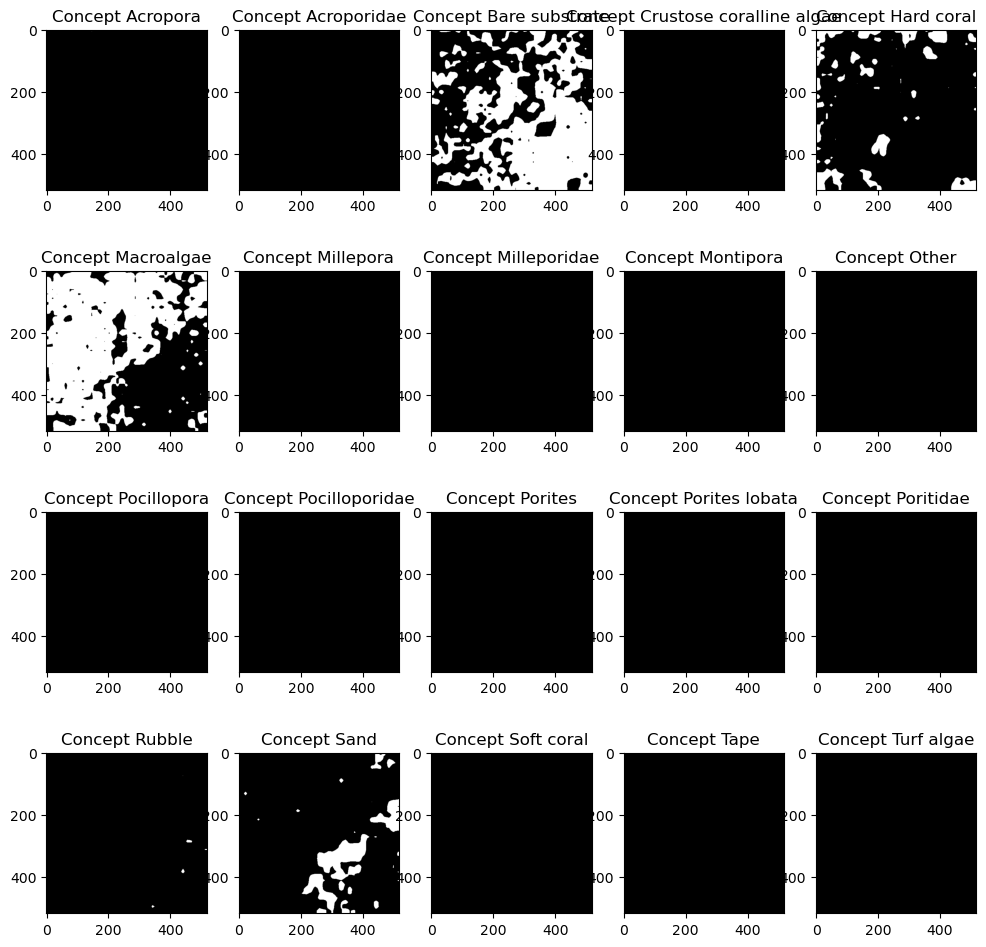

In [ ]:
fig, ax = plt.subplots(figsize=(12,12), nrows = 4, ncols = 5)
for i in range(20):
    sig = np.where(torch.sigmoid(tmp[1][i]).cpu().detach().numpy()>0.2, 1,0)
    plt.subplot(4,5,i+1)
    plt.imshow(sig, cmap='gray', vmin = 0, vmax = 1)
    plt.title(f"Concept {dataset.id2concept[i+1]}")
plt.show()